<a href="https://colab.research.google.com/github/Khey17/100-Days-Of-ML-Code/blob/main/Learn-TensorFlow/Milestone_Project_SkimLit_NLP_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 📃🔥

The purpose of this notebook is to build NLP model to make reading medical abstracts easier.

> The paper we're replicating (source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071


> And reading through the paper above, we see that model architecture that the y use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ef55a77f-971f-844c-7812-9bf536c2fccf)


## Get Data

Since we'll be replicating the paper above (PubMed 200k RCT dataset) let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


🔑 **Note:** dev is also known as validation set in the world of Machine Learning.

In [4]:
# Start our experiments using the 20k dataset with numbers replaced with at_sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with data is to...

> Visualize, Visualzie, Visualzie
So with that in mind, let's write a function to read in all of the lines of a target file.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  '''
  Reads filename (a text filename) and returns the lines of text as a list.
  Args:
    filename: a string containing the target filepath

  Return:
    A list of strings with one string per line from the target filename.
  '''

  with open(filename, 'r') as f:
    return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20] # the whole first example of the training data

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

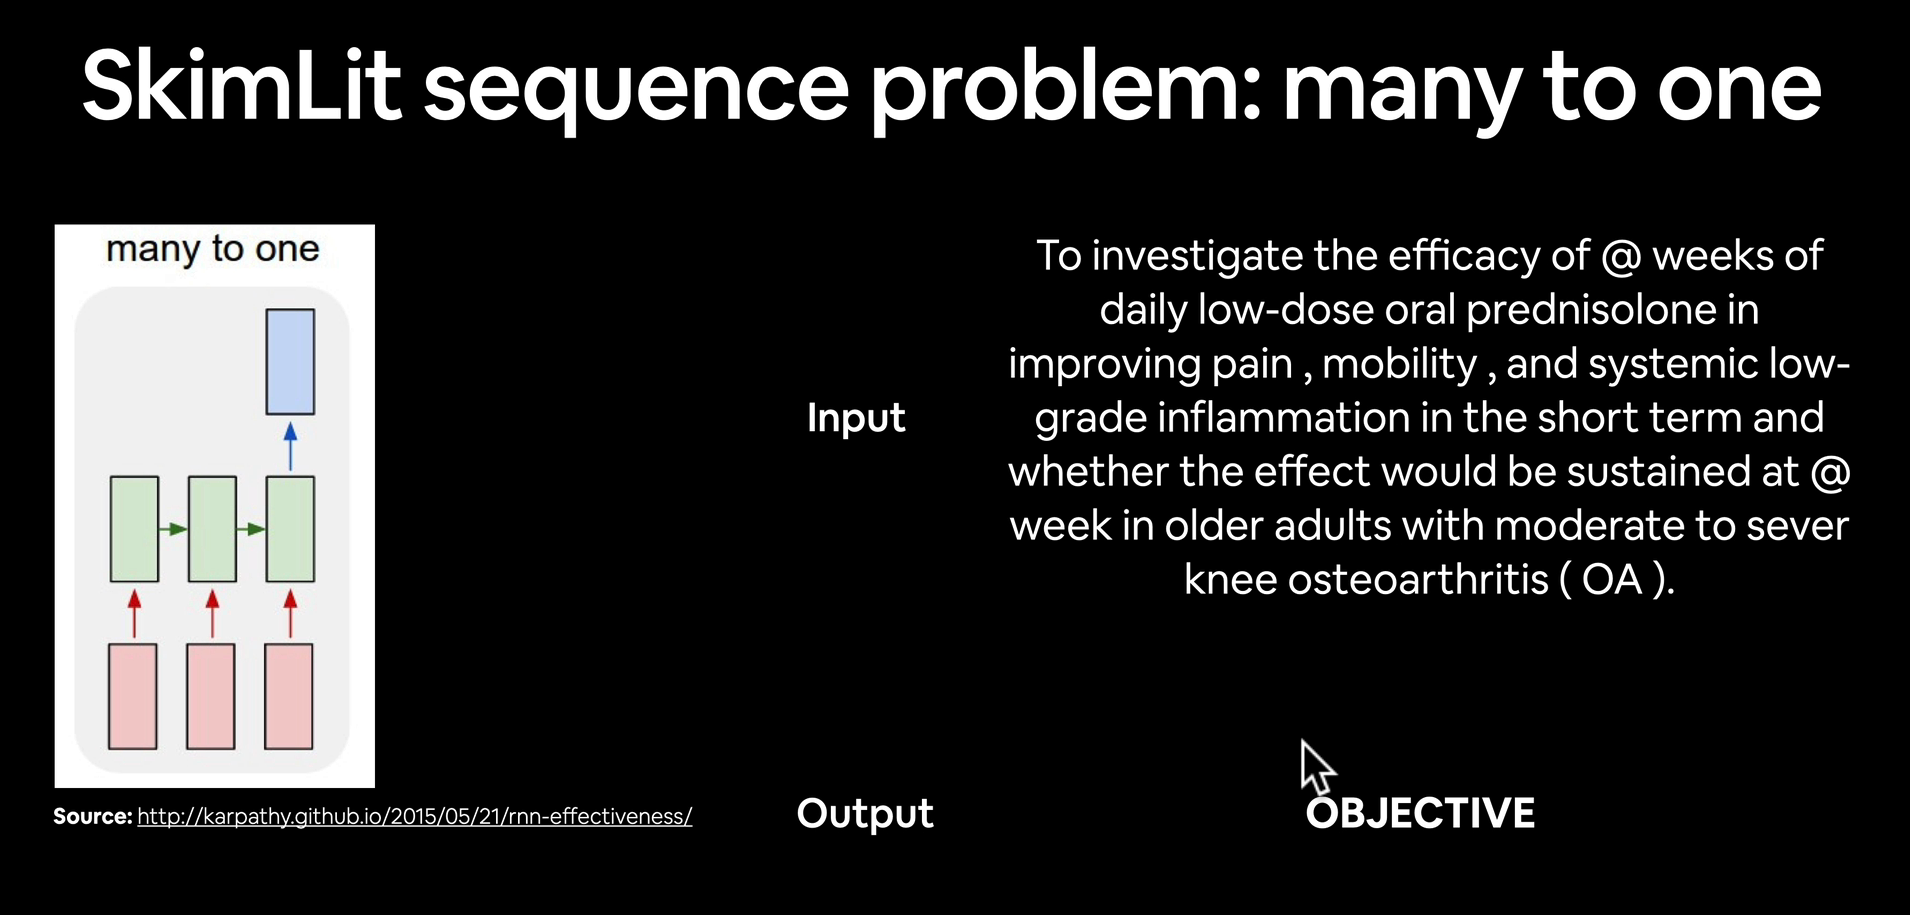

In [8]:
len(train_lines)

210040

Think about how you want your data to look...

How I think our data would be best represented...

```
[{'line number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines': 11}]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [9]:
def preprocess_text_data(filename):
  '''
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  '''

  input_lines = get_lines(filename)  # get all lines from filename
  abstract_lines = ""  # create an empty abstract
  abstract_samples = []  # empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:

    if line.startswith("###"):  # if line is an ID line
      abstract_id = line
      abstract_lines = ""  # reset abstract string

    elif line.isspace():  # if line is a new line
      abstract_line_split = abstract_lines.splitlines()  # split abstract into separate lines
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):  # return current abstract_line_number

        line_data = {}  # create empty dict to store data from line

        line_data['line number'] = abstract_line_number  # get current line number
        line_data['target'] = abstract_line.split("\t")[0]  # get label from line
        line_data['text'] = abstract_line.split('\t')[1].lower()  # get current line
        line_data['total_lines'] = len(abstract_line_split) - 1  # get total lines in abstract

        abstract_samples.append(line_data)  # add line data to abstract samples list

    else:
      abstract_lines += line  # append abstract line to string

  return abstract_samples


In [10]:
preprocess_text_data(data_dir + "train.txt")

[{'line number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [11]:
# Get the data from file and preprocess it
%%time
train_samples = preprocess_text_data(data_dir + "train.txt")
dev_samples = preprocess_text_data(data_dir + "dev.txt")
test_samples = preprocess_text_data(data_dir + "test.txt")

len(train_samples), len(dev_samples), len(test_samples)

CPU times: user 445 ms, sys: 101 ms, total: 546 ms
Wall time: 552 ms


(180040, 30212, 30135)

In [12]:
# Check the first 10 abstract samples of our training data
train_samples[:13]

[{'line number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of a list of dictionaries, let's turn them into a dataframe

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
dev_df = pd.DataFrame(dev_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
train_df.head(13)

,line number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [15]:
# Distribution of labels
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

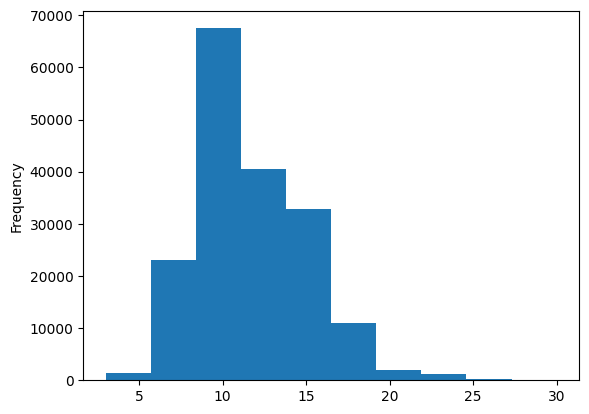

In [16]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [17]:
# Convert abstract text lines into lists
train_sentences = train_df.text.tolist()
dev_sentences = dev_df.text.tolist()
test_sentences = test_df.text.tolist()
len(train_sentences), len(dev_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Turning our target labels into numbers

In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)  # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
dev_labels_one_hot = one_hot_encoder.transform(dev_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))  # We want non-sparse matrix

# check what one hot encoded labels look like
train_labels_one_hot.shape, dev_labels_one_hot.shape, test_labels_one_hot.shape

((180040, 5), (30212, 5), (30135, 5))

### Label encode labels

In [20]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
dev_labels_encoded = label_encoder.transform(dev_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what label integers look like
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [21]:
# Get class names and number of classes from labelEncoder isntance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments we're running
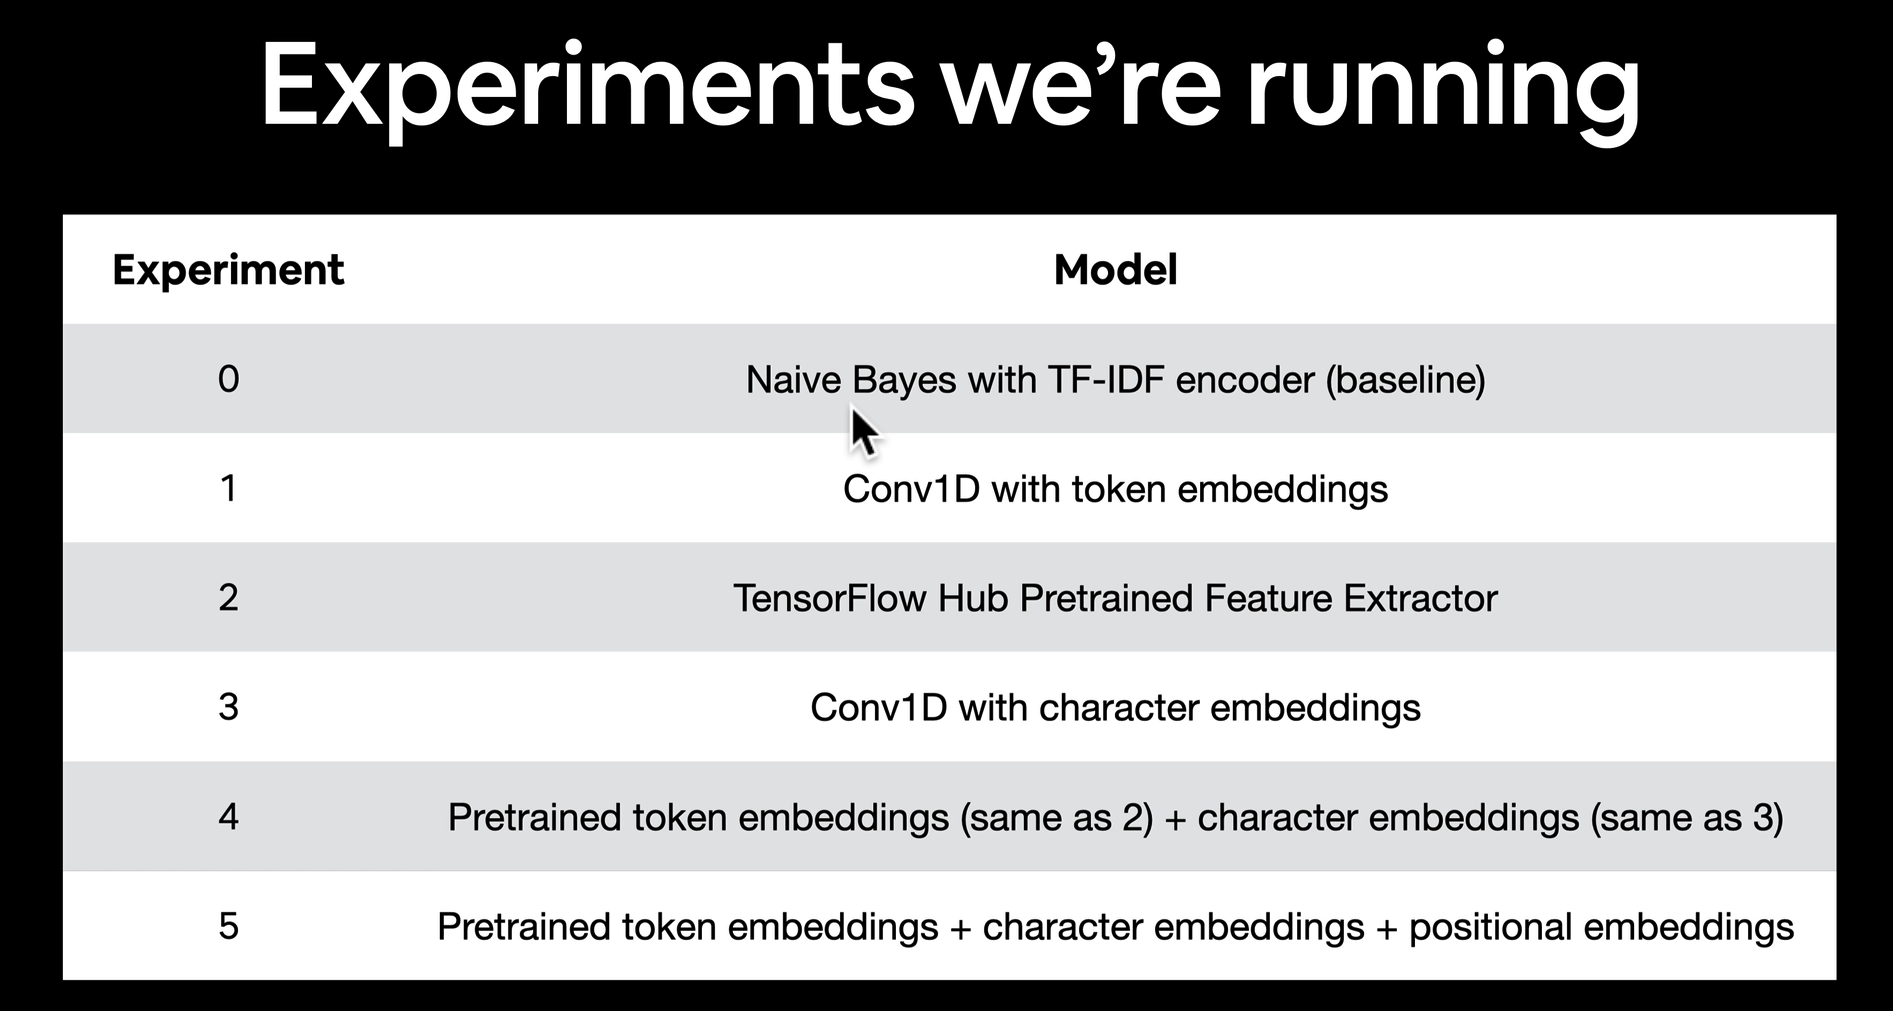

## Starting a series of modelling experiments...

As usual, we're going to be trying bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial classifier)

Checkout Chris Albon

### Model 0: Naive Bayes with TF-IDF encoder (baseline)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline model on validation dataset
model_0.score(X=dev_sentences, y=dev_labels_encoded)

0.7218323844829869

What happens in the backend (Pipeline)

In [24]:
# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(train_sentences)
# X_train_counts.shape

In [25]:
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_train_tfidf.shape

In [26]:
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB().fit(X_train_tfidf, train_labels_encoded);

In [27]:
# dev_sentences_counts = count_vect.transform(dev_sentences)
# dev_sentences_tfidf = tfidf_transformer.transform(dev_sentences_counts)

# clf.score(dev_sentences_tfidf, dev_labels_encoded)

In [28]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(dev_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

### Download the helper functions script

In the previous module, we wrote to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script

In [29]:
# Download the script
!wget https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py

--2024-04-10 10:12:36--  https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16634 (16K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.24K  --.-KB/s    in 0s      

2024-04-10 10:12:36 (126 MB/s) - ‘helper.py’ saved [16634/16634]



In [30]:
from helper import *

In [31]:
model_0_results = ModelEvaluation.results(y_true=dev_labels_encoded,
                                          y_pred=baseline_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

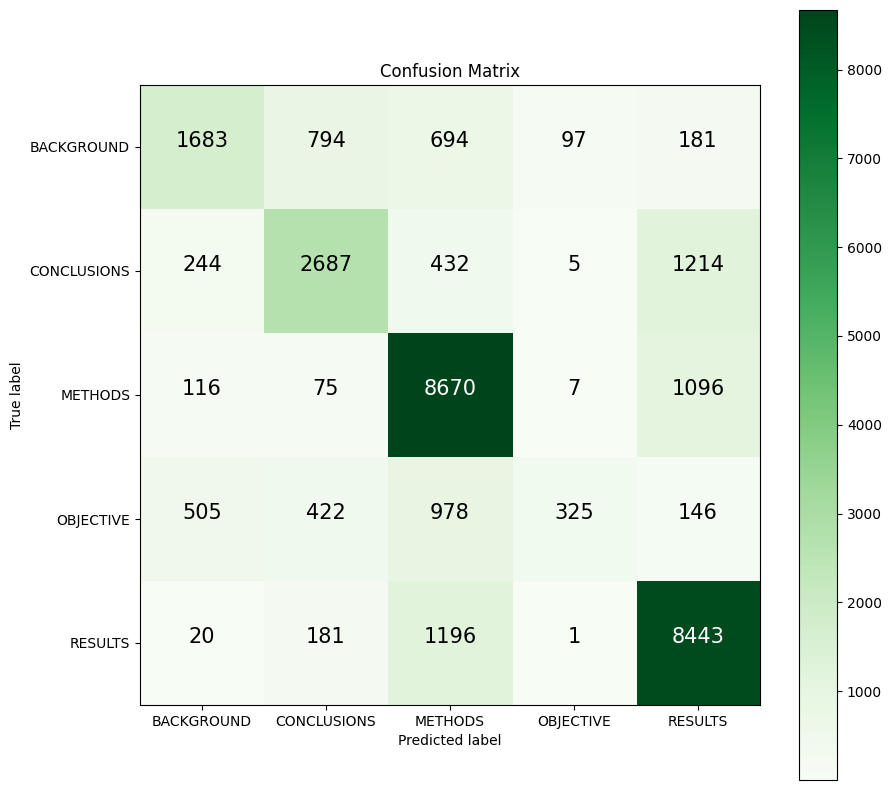

In [32]:
# Visualize the predictions
ModelEvaluation.make_confusion_matrix(y_true=dev_labels_encoded,
                               y_pred=baseline_preds,
                               classes=list(class_names))

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
sent_lens = [len(i.split()) for i in train_sentences]
sent_lens[:5], round(np.mean(sent_lens))

([49, 27, 15, 14, 35], 26)

In [34]:
# import text vectorization from tensorflow
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
MAX_VOCAB_SIZE = 68000  # refer to PubMed RCT paper
MAX_LENGTH = int(np.percentile(sent_lens, 95))  # How long of a sentence covers 95% of data

text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB_SIZE,
                                    standardize='lower_and_strip_punctuation',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=MAX_LENGTH,
                                    pad_to_max_tokens=True)
text_vectorizer.adapt(np.array(train_sentences))

text_vectorizer([train_sentences[0]])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   6,  331,    2,   79,    4,   53,    4,  161, 1127,  217, 2535,
           5,  557,   65, 1584,    3,  670, 5559,  636,    5,    2,  654,
        1137,    3,  180,    2,   70,  495,   36,  781,   15,   53,    5,
         350,  266,    7,  362,    6,  289,  517, 1430, 1743,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

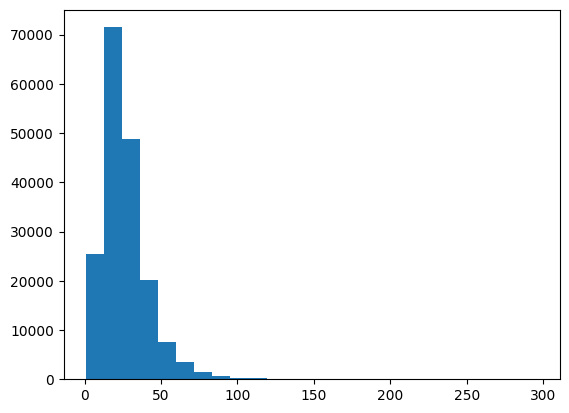

In [35]:
# What's the distribution like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25);

In [36]:
np.percentile(sent_lens, 95)

55.0


### Creating an Embedding using an Embedding layer
To make our embedding, we're going to use TensorFlow's [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer

The parameters we care most about for our embedding layer:

* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a avalue of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [37]:
# import Embedding from keras.layers
from keras.layers import Embedding

embedding = Embedding(input_dim=MAX_VOCAB_SIZE,  # set input shape
                            output_dim=128,  # set output shape
                            embeddings_initializer='uniform',  # set initializer
                            mask_zero=True,  # Use masking to handle variable sequence lengths
                            input_length=MAX_LENGTH  # how long is each input
                            )

embedding

In [38]:
# View a sample after embedding
embedding(text_vectorizer([train_sentences[0]]))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.0142434 , -0.03998918, -0.00361566, ..., -0.00874429,
         -0.04121612,  0.04477659],
        [ 0.04013613, -0.0399137 , -0.00399042, ..., -0.00180794,
         -0.02374343, -0.03387916],
        [-0.02112408,  0.0014491 ,  0.02139721, ...,  0.0236923 ,
          0.04798568,  0.04573325],
        ...,
        [ 0.01879964, -0.02128555,  0.02584774, ...,  0.01823305,
          0.00967522, -0.04581375],
        [ 0.01879964, -0.02128555,  0.02584774, ...,  0.01823305,
          0.00967522, -0.04581375],
        [ 0.01879964, -0.02128555,  0.02584774, ...,  0.01823305,
          0.00967522, -0.04581375]]], dtype=float32)>

In [39]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow [tf.data.API](https://www.tensorflow.org/guide/data)

refer to: https://www.tensorflow.org/guide/data_performance

In [40]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset, dev_dataset, test_dataset

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

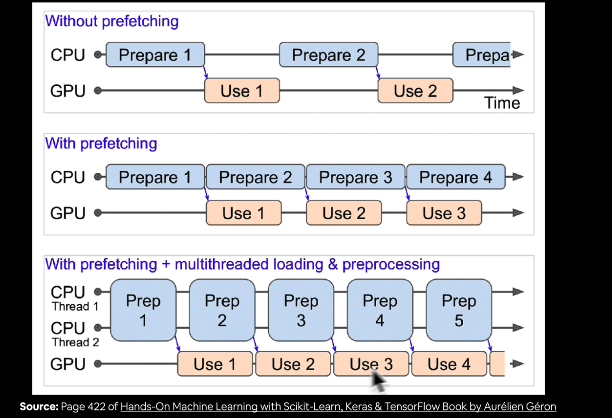

In [41]:
# let's prefetech and convert our data into batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [42]:
rct_20k_text_vocab[:5]

['', '[UNK]', 'the', 'and', 'of']

### Deep Sequence Models

Now that we've preprocessed the text data through text vectorization (tokenizing) and embedding, let's go ahead and build the Deep sequence models using functional API.

### Model 1: Conv1D with token embeddings

In [43]:
# Creating model logs directory to track the training progress
dir = 'model_logs'

0# Build the Conv1D model using Functional API
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_Conv1D')

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=dev_dataset,
                              validation_steps=int(0.1 * len(dev_dataset)),
                              callbacks=Callback.create_tensorboard(dir_name=dir,
                                                                    experiment_name='Model_1_Conv1D'))

Saving TensorBoard log files to: model_logs/Model_1_Conv1D/20240410-101258
Epoch 1/3
562/562 [==============================] - 20s 31ms/step - loss: 0.9428 - accuracy: 0.6244 - val_loss: 0.7257 - val_accuracy: 0.7234
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6954 - accuracy: 0.7367 - val_loss: 0.6641 - val_accuracy: 0.7613
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6496 - accuracy: 0.7595 - val_loss: 0.6241 - val_accuracy: 0.7713


In [44]:
# Get the summary
model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)              

In [45]:
# Evaluate the model
model_1.evaluate(dev_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6276 - accuracy: 0.7743


[0.6276494264602661, 0.7742618918418884]

In [46]:
# Make predictions with dev_dataset
model_1_pred_probs = model_1.predict(dev_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.31060493e-01, 1.70623705e-01, 8.75973254e-02, 2.82985926e-01,
        2.77325716e-02],
       [5.02307117e-01, 1.98590472e-01, 1.63887665e-02, 2.75747448e-01,
        6.96622580e-03],
       [2.36510351e-01, 3.26713063e-02, 5.93833067e-03, 7.24764764e-01,
        1.15141753e-04],
       ...,
       [3.48175058e-06, 7.42226839e-04, 7.29227730e-04, 2.52562450e-06,
        9.98522580e-01],
       [5.89769259e-02, 4.38787818e-01, 1.31935269e-01, 8.15344006e-02,
        2.88765609e-01],
       [2.34856501e-01, 4.44418073e-01, 1.01356715e-01, 9.75937843e-02,
        1.21774919e-01]], dtype=float32)

In [47]:
# Convert the pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
# Calculate model_1 results
model_1_results = ModelEvaluation.results(y_true=dev_labels_encoded,
                        y_pred=model_1_preds)
model_1_results

{'accuracy': 77.42618826956176,
 'precision': 0.7690099592244622,
 'recall': 0.7742618826956177,
 'f1': 0.7706615566489842}

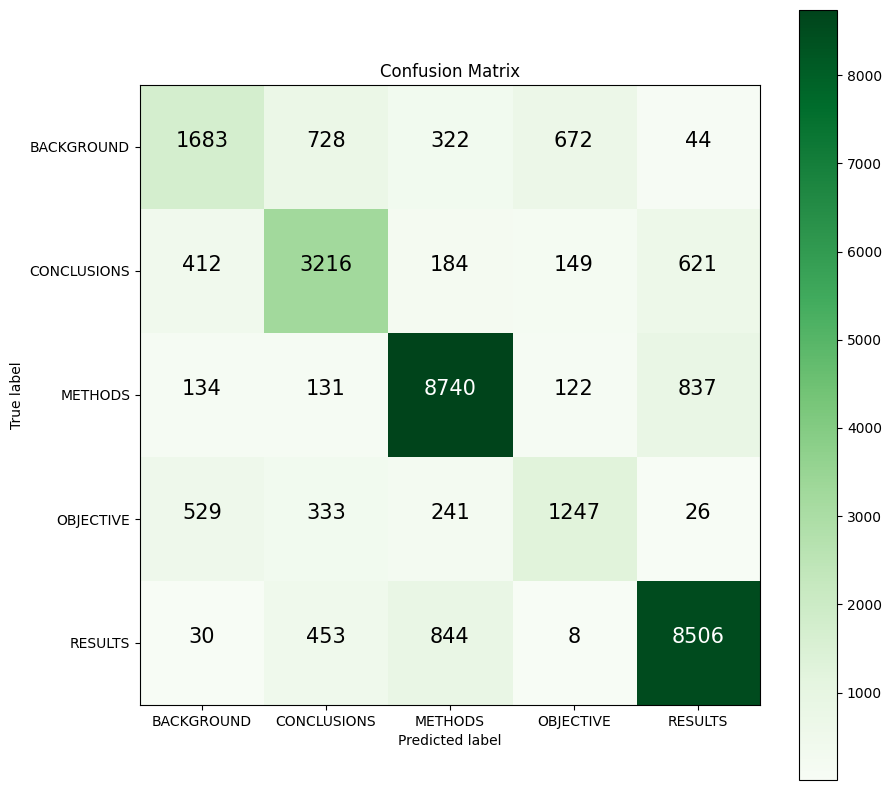

In [49]:
# Visualize the predictions
ModelEvaluation.make_confusion_matrix(y_true=dev_labels_encoded,
                                 y_pred=model_1_preds, classes=list(class_names))

## Model 2: TensorFlow-Hub Pretrained Feature Extractor

Now lets use the Universal Sentence Encoder pretrained model.

Refer to Huggingface & Tf-hub/Kaggle-Models for more pretrained models

Let's GloVe embedding from keras: https://keras.io/examples/nlp/pretrained_word_embeddings/

In [50]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [51]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n{random_train_sentence}\n')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence}\n')
print(f'Length of sentence embedding:\n{len(use_embedded_sentence[0])}')

Random sentence:
patients with a history of myocardial infarction and higher euroscores were less likely to benefit from an add-on sa procedure .

Sentence after embedding:
[[-4.92268279e-02  7.93733541e-03 -2.72127055e-02 -8.10764581e-02
  -5.44872656e-02  5.45909535e-03 -5.77768683e-03 -4.30881940e-02
  -1.76299624e-02 -1.55399619e-02  1.04956344e-01 -3.81678417e-02
   6.75391685e-03  4.31464240e-03 -1.34207318e-02  1.01195993e-02
  -1.05020046e-01  4.20761714e-03 -2.23305933e-02  1.20340260e-02
   6.83311448e-02  7.78462291e-02 -3.86605933e-02 -1.54103301e-02
  -3.89121822e-04 -5.27309366e-02  4.52501327e-02 -9.90101835e-04
  -1.16301123e-02 -4.06553224e-03 -8.22945294e-05  1.06055029e-01
   2.92488988e-02  3.66554186e-02  2.97917034e-02  6.73063332e-04
  -2.11096276e-02  5.37581109e-02 -6.63522929e-02 -9.68429595e-02
   1.20703075e-02 -1.48850642e-02  6.07586838e-02 -5.26973642e-02
   7.37662800e-03  3.69870253e-02  3.32080983e-02 -4.29623686e-02
  -2.90612150e-02  1.30302664e-02 -

In [52]:
# Let's build our Model 2
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)  # tokenize text and create embedding sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)  # add a fully connected layer on top of the embedding sequence
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=dev_dataset,
                              validation_steps=int(0.1 * len(dev_dataset)),
                              callbacks=Callback.create_tensorboard(dir_name=dir,
                                                                    experiment_name='Model_2_USE'))

Saving TensorBoard log files to: model_logs/Model_2_USE/20240410-101432
Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9203 - accuracy: 0.6510 - val_loss: 0.7957 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7669 - accuracy: 0.7022 - val_loss: 0.7509 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7483 - accuracy: 0.7147 - val_loss: 0.7323 - val_accuracy: 0.7131


In [53]:
# Evaluate the model
model_2.evaluate(dev_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7371 - accuracy: 0.7160


[0.7370954155921936, 0.7159737944602966]

In [54]:
# Make predictions with the dev dataset
model_2_pred_probs = model_2.predict(dev_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[4.2463630e-01, 3.5906065e-01, 2.1081811e-03, 2.0676482e-01,
        7.4300384e-03],
       [3.6667886e-01, 4.7741988e-01, 2.9331723e-03, 1.5092285e-01,
        2.0451655e-03],
       [2.2349064e-01, 1.5080713e-01, 1.6564749e-02, 5.6486994e-01,
        4.4267587e-02],
       ...,
       [2.2462248e-03, 5.0737630e-03, 4.5328509e-02, 9.3908625e-04,
        9.4641244e-01],
       [5.5415970e-03, 4.2343147e-02, 2.0151986e-01, 1.7594029e-03,
        7.4883598e-01],
       [1.7016840e-01, 2.6621833e-01, 4.9383876e-01, 7.5600967e-03,
        6.2214304e-02]], dtype=float32)

In [55]:
# Convert the prediction probabilities found with feature extractor into label encoded
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
# Check the results
model_2_results = ModelEvaluation.results(y_true=dev_labels_encoded,
                        y_pred=model_2_preds)
model_2_results

{'accuracy': 71.59737852508937,
 'precision': 0.7158358427276486,
 'recall': 0.7159737852508937,
 'f1': 0.7127450307347164}

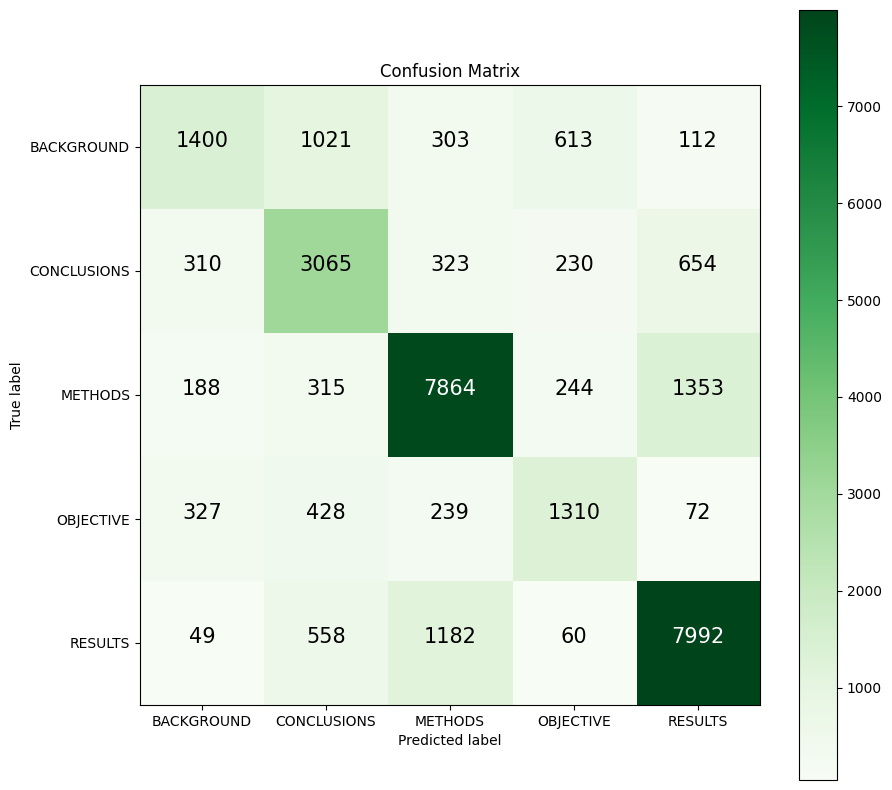

In [57]:
# Display confusion matrix
ModelEvaluation.make_confusion_matrix(y_true=dev_labels_encoded,
                                 y_pred=model_2_preds, classes=list(class_names))

## Model 3: Conv1D with Character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do a similar steps for characters if we want to use char-level embeddings.

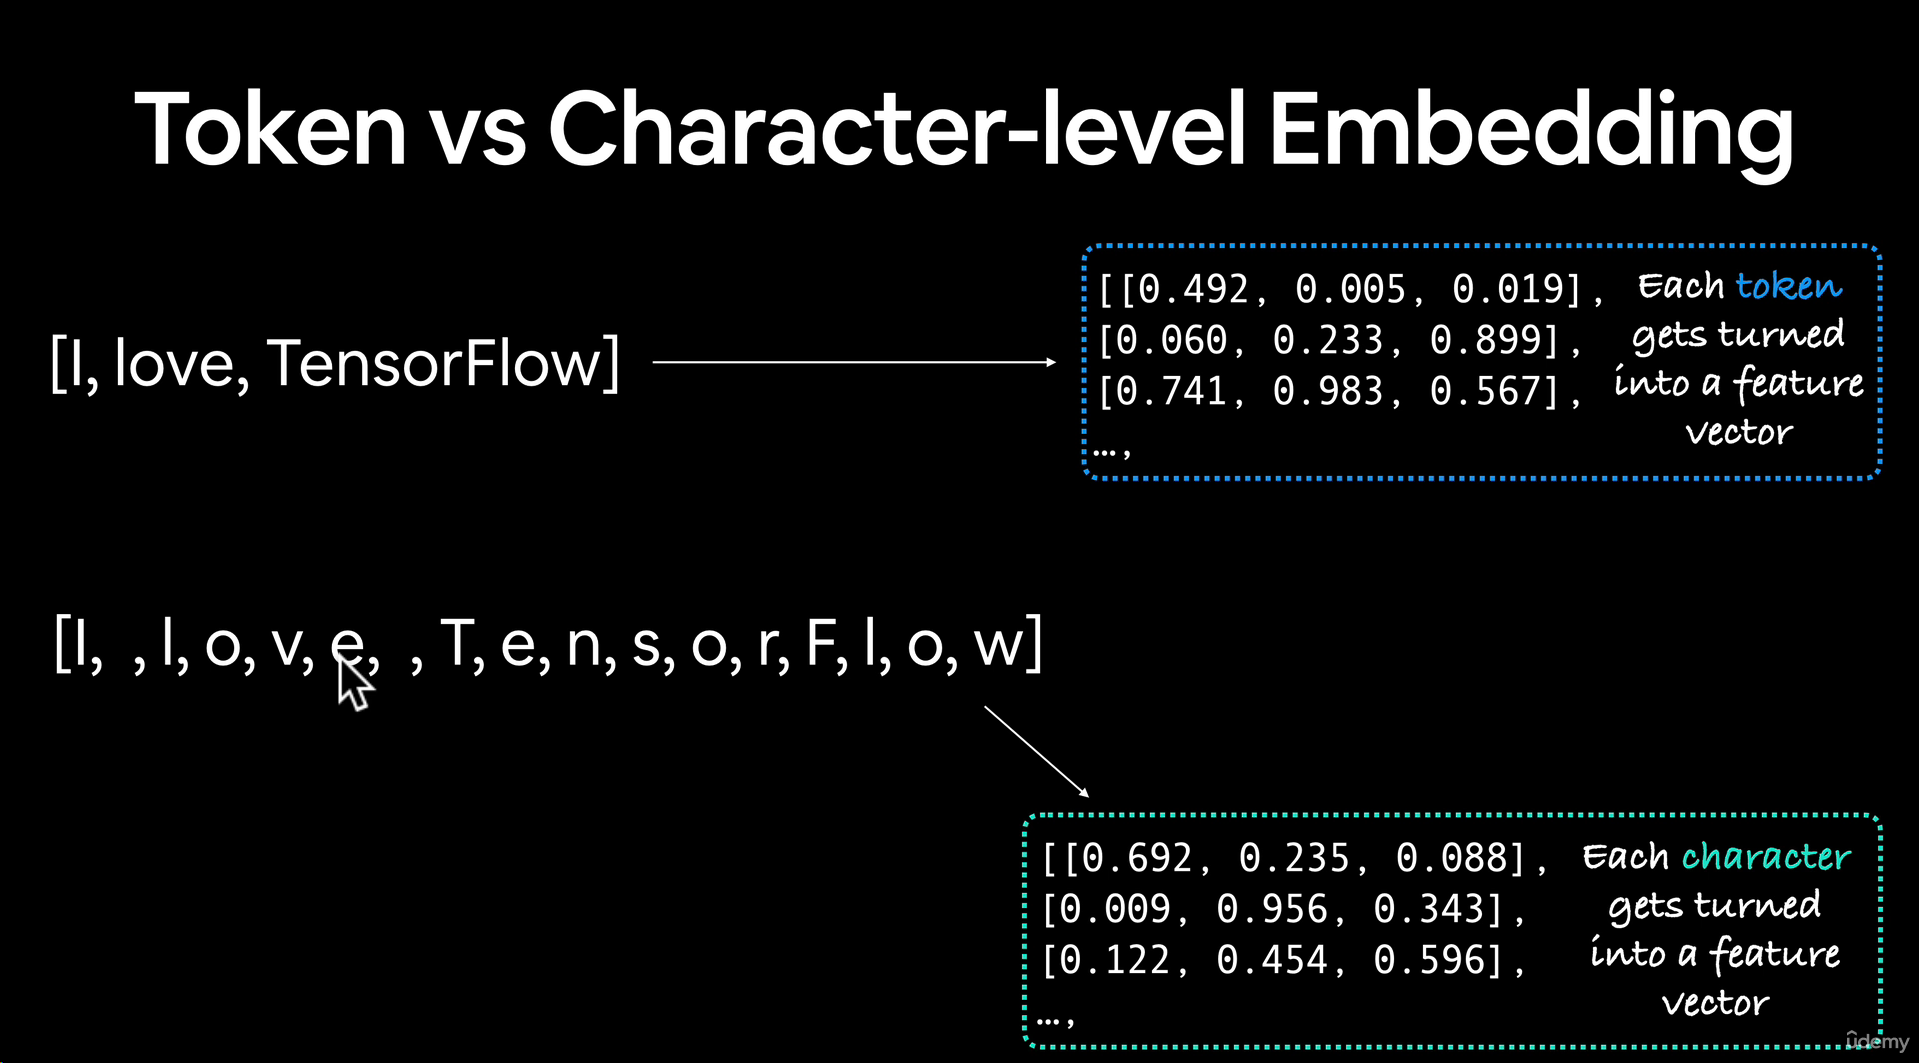

### Create a character level tokenizer

In [58]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [59]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'p a t i e n t s   w i t h   a   h i s t o r y   o f   m y o c a r d i a l   i n f a r c t i o n   a n d   h i g h e r   e u r o s c o r e s   w e r e   l e s s   l i k e l y   t o   b e n e f i t   f r o m   a n   a d d - o n   s a   p r o c e d u r e   .'

In [60]:
# Split sequence level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
dev_chars = [split_chars(sentence) for sentence in dev_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
# What's the avg character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = sum(char_lens) / len(char_lens)
mean_char_len

149.3662574983337

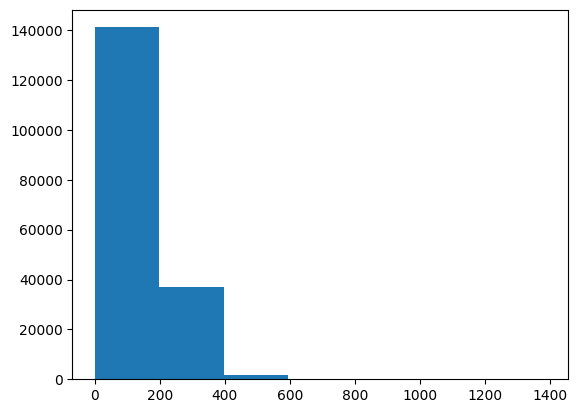

In [62]:
# CHeck the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [63]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [64]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # Add 2 token (OOV = out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None,  # Set standardization to None if you want to keep punctuations.
                                    split="character",
                                    ngrams=None,
                                    output_mode="int",
                                    pad_to_max_tokens=True,
                                    name= "char_vectorizer")

# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [66]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 29
5 most common characters: ['', '[UNK]', ' ', 'e', 't']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Creating a character level embedding layer

In [67]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e   r a d i a t i o n   t h e r a p y   o n c o l o g y   g r o u p   l a u n c h e d   a   p h a s e   i i i   t r i a l   t o   t e s t   t h e   h y p o t h e s i s   t h a t   a d d i n g   c e t u x i m a b   t o   t h e   r a d i a t i o n - c i s p l a t i n   p l a t f o r m   i m p r o v e s   p r o g r e s s i o n - f r e e   s u r v i v a l   (   p f s   )   .
Length of random_train_chars: 377
Vectorized chars:
 [[ 4  2 14  2  3  2  2  2  9  2  6  2 11  2  5  2  6  2  4  2  5  2  8  2
   7  2  2  2  4  2 14  2  3  2  9  2  6  2 15  2 20  2  2  2  8  2  7  2
  12  2  8  2 13  2  8  2 19  2 20  2  2  2 19  2  9  2  8  2 17  2 15  2
   2  2 13  2  6  2 17  2  7  2 12  2 14  2  3  2 11  2  2  2  6  2  2  2
  15  2 14  2  6  2 10  2  3  2  2  2  5  2  5  2  5  2  2  2  4  2  9  2
   5  2  6  2 13  2  2  2  4  2  8  2  2  2  4  2  3  2 10  2  4  2  2  2
   4  2 14  2  3  2  2  2 14  2 20  2 15  2  8  2  4  2 14  2  3  2 10  2
   5  2 10  2  2  2  4  2 14  2  6

In [68]:
# text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB_SIZE,
#                                     standardize='lower_and_strip_punctuation',
#                                     ngrams=None,
#                                     output_mode='int',
#                                     output_sequence_length=MAX_LENGTH,
#                                     pad_to_max_tokens=True)

# embedding = Embedding(input_dim=MAX_VOCAB_SIZE,  # set input shape
#                             output_dim=128,  # set output shape
#                             embeddings_initializer='uniform',  # set initializer
#                             mask_zero=True,  # Use masking to handle variable sequence lengths
#                             input_length=MAX_LENGTH  # how long is each input
#                             )

In [69]:
char_embedding = Embedding(input_dim=len(char_vocab),
                                      output_dim=25, # this is the size of the char embedding in the paper: htps://arxiv.org/pdf/1612.05251.pdf (Fig 1)
                                      mask_zero=True,
                                      # input_length=output_seq_char_len,
                                      name="char_embed")

# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_chars)
print(f'Random sentence:\n{random_train_sentence}\n')
use_embedded_sentence = char_embedding(char_vectorizer([random_train_sentence]))
print(f'Sentence after char embedding:\n{use_embedded_sentence}\n')
print(f'char embedding shape:\n{use_embedded_sentence.shape}')

Random sentence:
t h e   m e d i a n   a g e   w a s   @   a n d   @   %   w e r e   m a l e   .

Sentence after char embedding:
[[[ 0.01570636  0.04375244  0.04860903 ... -0.0079645  -0.01531234
   -0.00935689]
  [-0.03747986  0.03335163  0.02192045 ...  0.02880747  0.02256751
   -0.0073509 ]
  [-0.01364269 -0.00766821  0.03539411 ...  0.0133921   0.03531534
    0.00694676]
  ...
  [-0.04972683  0.02249033  0.02300871 ... -0.04443583 -0.04442349
   -0.04919486]
  [-0.04972683  0.02249033  0.02300871 ... -0.04443583 -0.04442349
   -0.04919486]
  [-0.04972683  0.02249033  0.02300871 ... -0.04443583 -0.04442349
   -0.04919486]]]

char embedding shape:
(1, 290, 25)


In [70]:
use_embedded_sentence[0][0]

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([ 0.01570636,  0.04375244,  0.04860903,  0.04832703,  0.00872985,
       -0.04531983, -0.01324828, -0.00715142,  0.00123919,  0.00541829,
        0.03230074, -0.0197052 ,  0.00681348,  0.02968406, -0.03803725,
        0.03850955,  0.00690145,  0.00965919, -0.04245615,  0.03900156,
        0.00250386, -0.03687034, -0.0079645 , -0.01531234, -0.00935689],
      dtype=float32)>

In [71]:
# Build a Conv1D model with character embedding
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
x = layers.Conv1D(128, kernel_size=5, padding='same', activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get the summary()
model_3.summary()

Model: "model_3_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           725       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 128)          16128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)              

### Creating char-level datasets

In [72]:
# Create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
dev_char_dataset = tf.data.Dataset.from_tensor_slices((dev_chars, dev_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
train_char_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [73]:
# Convert our data into batches
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_char_dataset = dev_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [74]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=dev_char_dataset,
                              validation_steps=int(0.1 * len(dev_char_dataset)),
                              callbacks=Callback.create_tensorboard(dir, 'model_3_char_embed_Conv1D'))

Saving TensorBoard log files to: model_logs/model_3_char_embed_Conv1D/20240410-101634
Epoch 1/3
562/562 [==============================] - 7s 9ms/step - loss: 1.2987 - accuracy: 0.4641 - val_loss: 1.0892 - val_accuracy: 0.5698
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 1.0288 - accuracy: 0.5911 - val_loss: 0.9611 - val_accuracy: 0.6240
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9463 - accuracy: 0.6303 - val_loss: 0.8980 - val_accuracy: 0.6430


In [75]:
# Evaluate the model
model_3.evaluate(test_char_dataset)

942/942 [==============================] - 5s 5ms/step - loss: 0.9163 - accuracy: 0.6391


[0.9162502884864807, 0.6390575766563416]

In [76]:
# Make predictions and get the report
model_3_pred_probs = model_3.predict(dev_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
ModelEvaluation.results(y_true=dev_labels_encoded, y_pred=model_3_preds)

945/945 [==============================] - 5s 5ms/step


{'accuracy': 64.60346882033629,
 'precision': 0.6419132609473025,
 'recall': 0.6460346882033629,
 'f1': 0.6309956576517088}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf)

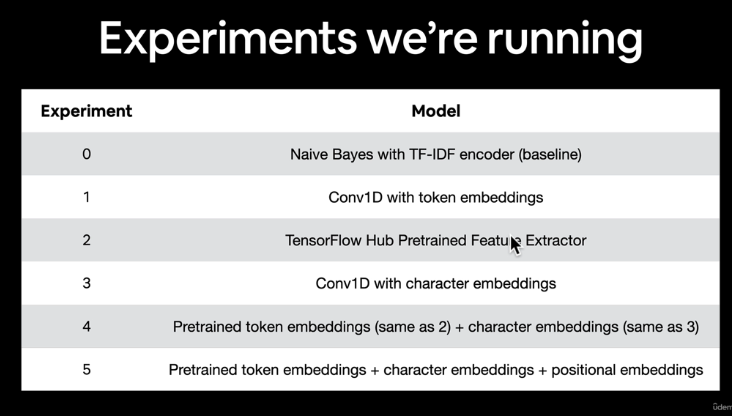

In the paper, They use a combination of Token Embeddings and Character Embeddings.

## Model 4: Pretrained token embeddings (same as 2) + character embeddings (same as 3)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Cpmbine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top 3 similar to figure 1 and section 4.2: https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [77]:
# Building our first multi input model with keras functional api

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)  # bi-lstm shown in the paper
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropout, discussed in 4.2 section of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation='softmax')(final_dropout)

# 5. Combine model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer,
                         name='model_4_token_and_char_embeddings')  # pass in the model inputs

In [78]:
# Get the summary of the model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

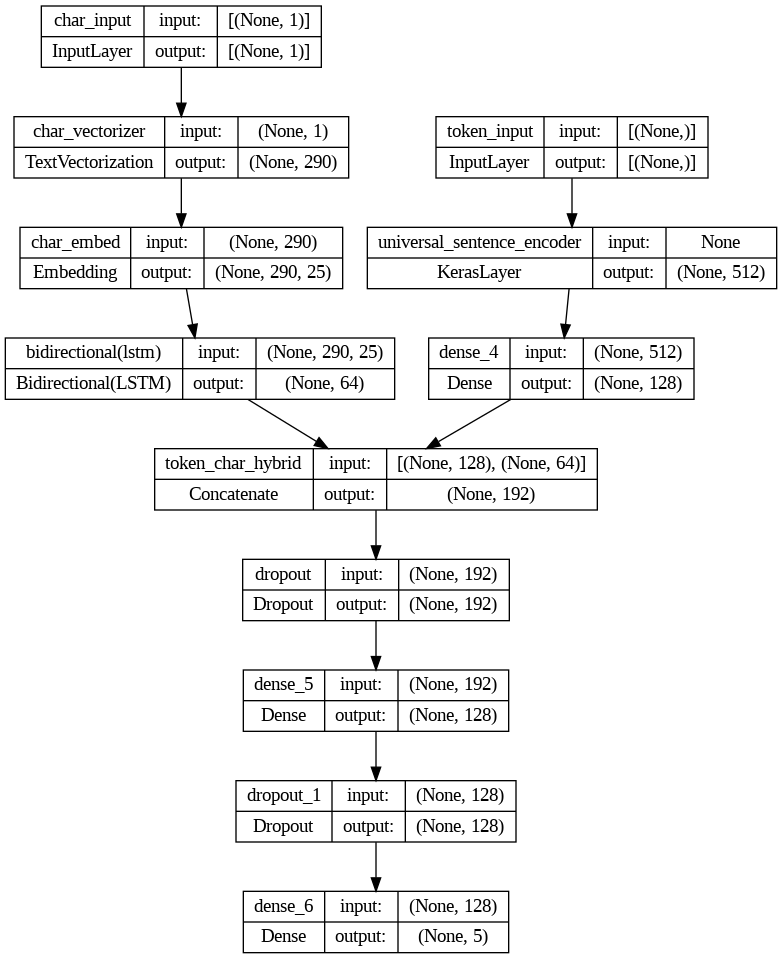

In [79]:
# Plot the hybrid token and character model
tf.keras.utils.plot_model(model_4, show_shapes=True)

### Loading our data (from multiple sources) into tensorflow dataset

build a pipeline using tf.data Dataset

In [80]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))  # make data into a dataset
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)  # make labels into a dataset
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))  # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)  # batch and prefetch

# Repeat the same for dev and test sets
dev_char_token_data = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_chars))
dev_char_token_labels = tf.data.Dataset.from_tensor_slices(dev_labels_one_hot)
dev_char_token_dataset = tf.data.Dataset.zip((dev_char_token_data, dev_char_token_labels))
dev_char_token_dataset = dev_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# test set
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset, dev_char_token_dataset, test_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [81]:
# Compile the model with SGD() and categorical crossentropy
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the combined model with the data
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=(dev_char_token_dataset),
                              validation_steps=int(0.1 * len(dev_char_token_dataset)),
                              callbacks=[Callback.create_tensorboard(dir_name=dir,
                                                                 experiment_name='model_4_multimodal')])

Saving TensorBoard log files to: model_logs/model_4_multimodal/20240410-101704
Epoch 1/3
562/562 [==============================] - 36s 45ms/step - loss: 0.9839 - accuracy: 0.6071 - val_loss: 0.7957 - val_accuracy: 0.6941
Epoch 2/3
562/562 [==============================] - 22s 40ms/step - loss: 0.8049 - accuracy: 0.6910 - val_loss: 0.7272 - val_accuracy: 0.7274
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7760 - accuracy: 0.7039 - val_loss: 0.7073 - val_accuracy: 0.7291


In [82]:
# Evaluate the model
model_4.evaluate(dev_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.7049 - accuracy: 0.7305


[0.7049403786659241, 0.7304713129997253]

In [83]:
# Results
model_4_pred_probs = model_4.predict(dev_char_token_dataset)
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = ModelEvaluation.results(y_true=dev_labels_encoded,
                                    y_pred=model_4_pred)
model_4_results

945/945 [==============================] - 23s 21ms/step


{'accuracy': 73.04713358930226,
 'precision': 0.7320887356660287,
 'recall': 0.7304713358930226,
 'f1': 0.7279918343026147}

## Model 5: Pretrained token embeddings + character embeddins + positional embeddings

Adding extra sources of data to our model using feature engineering.

In [84]:
# Let's look at the dictionaries created earlier
train_df.head()

,line number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers, and total lines are available.

### Create positional embeddings

In [85]:
# How many different line numbers are there?
train_df['line number'].value_counts()

line number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

In [86]:
# Use TensorFlow to create one-hot encoded tensors of our 'line number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line number'].to_numpy(), depth=16)  # get one-hot-encoded tensors of our line numbers -> Curse of dimensionality
test_line_numbers_one_hot = tf.one_hot(test_df['line number'].to_numpy(), depth=16)
dev_line_numbers_one_hot = tf.one_hot(dev_df['line number'].to_numpy(), depth=16)

train_line_numbers_one_hot[:2], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(2, 16), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 16]))

In [87]:
# Check the number of values in total_lines
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

In [88]:
#  Use TensorFlow to create one-hot encoded tensors of our 'total_lines' column
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)  # get one-hot-encoded tensors of our line numbers -> Curse of dimensionality
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)  # get one-hot-encoded tensors of our line numbers -> Curse of dimensionality
dev_total_lines_one_hot = tf.one_hot(dev_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:2], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

<Axes: >

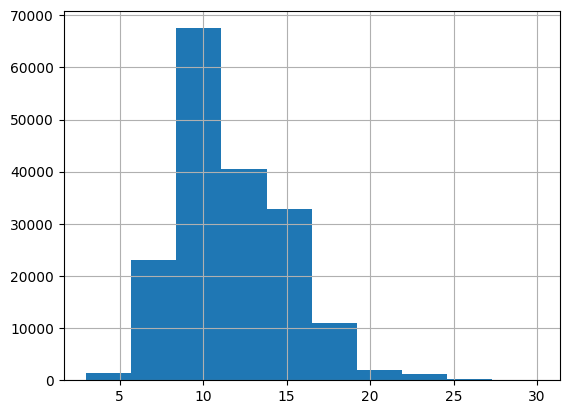

In [89]:
train_df['total_lines'].hist()

In [90]:
np.percentile(train_df['total_lines'], 98)

20.0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model `line number` feature
4. Create a model model for the `total_lines` feature
5. combine the outputs of 1 & 2 tf.keras.layers.Concatenate
6. Combine outputs of 3, 4, 5. using Concatenate
7. Create an output layer to accept the tribrid embedding and label probabilities
8. Combine the inputs of 1, 2, 3,4 and outputs into a tf.keras.Model

In [91]:
MAX_LENGTH, MAX_VOCAB_SIZE

(55, 68000)

In [92]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')  # token inputs
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)  # token outputs
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)  # bi-LSTM
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Create a model for 'line number'
line_inputs = layers.Input(shape=(16,), dtype=tf.float32, name='pos_input')
line_output = layers.Dense(32, activation='relu')(line_inputs)
line_model = tf.keras.Model(inputs=line_inputs,
                           outputs=line_output)

# 4. Create a model for 'total_lines'
tot_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='tot_input')
tot_output = layers.Dense(32, activation='relu')(tot_inputs)
tot_model = tf.keras.Model(inputs=tot_inputs,
                           outputs=tot_output)

# 5. Combine 1 & 2
combined_embeddings = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# Add a dropout layer
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine the outputs of 3 & 4
tribrid_embeddings = layers.Concatenate(name='token_char_positional_hybrid')([line_model.output, tot_model.output, z])  # Concatenate

# 7. Create an output layer
outputs = layers.Dense(5, activation='softmax', name='output')(tribrid_embeddings)  # output
tribrid_model = tf.keras.Model(inputs=[line_model.input, tot_model.input, token_model.input, char_model.input],
                               outputs=outputs, name='tribrid_model')

In [93]:
tribrid_model.summary()

Model: "tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0

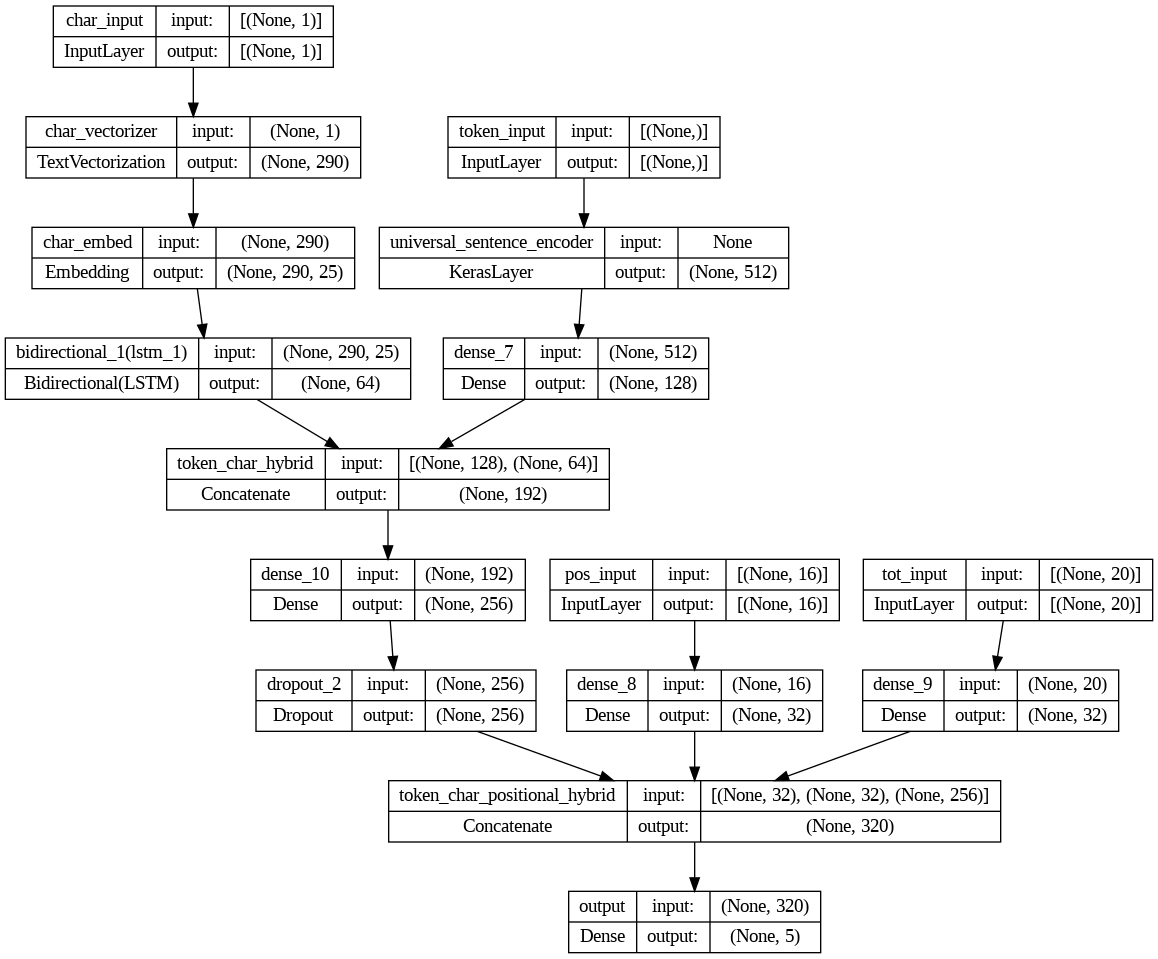

In [94]:
# Plot the tribrid model using utils
tf.keras.utils.plot_model(tribrid_model, show_shapes=True)

### Create tribrid datasets using tf.data

In [95]:
# Load dataset by combining tokens, chars, line number and total lines
train_tri_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))
train_tri_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tri_dataset = tf.data.Dataset.zip((train_tri_data, train_tri_labels))

# Prefetch and batch train data
train_tri_dataset = train_tri_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# repeat the same for dev
dev_tri_data = tf.data.Dataset.from_tensor_slices((dev_line_numbers_one_hot, dev_total_lines_one_hot, dev_sentences, dev_chars))
dev_tri_labels = tf.data.Dataset.from_tensor_slices(dev_labels_one_hot)
dev_tri_dataset = tf.data.Dataset.zip((dev_tri_data, dev_tri_labels))

dev_tri_dataset = dev_tri_dataset.batch(32).prefetch(tf.data.AUTOTUNE)  # batch and prefetch dev data

train_tri_dataset, dev_tri_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consifer other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0]`

What label smoothing does is it assigns some of the value from the highes pred prob to other classes, in turn hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> Refer to tensorflow documentation for more details about label_smoothing.

In [96]:
# Comile the model
tribrid_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

# Fit the tribrid model
model_5_history = tribrid_model.fit(train_tri_dataset,
                                    steps_per_epoch=int(0.1 * len(train_tri_dataset)),
                                    epochs=5,
                                    validation_data=dev_tri_dataset,
                                    validation_steps=int(0.1 * len(dev_tri_dataset)),
                                    callbacks=Callback.create_tensorboard(dir, 'tribrid_model'))  # create tensorboard callback

Saving TensorBoard log files to: model_logs/tribrid_model/20240410-101921
Epoch 1/5
562/562 [==============================] - 37s 47ms/step - loss: 1.0990 - accuracy: 0.7238 - val_loss: 0.9814 - val_accuracy: 0.8082
Epoch 2/5
562/562 [==============================] - 23s 42ms/step - loss: 0.9666 - accuracy: 0.8151 - val_loss: 0.9483 - val_accuracy: 0.8344
Epoch 3/5
562/562 [==============================] - 23s 42ms/step - loss: 0.9482 - accuracy: 0.8270 - val_loss: 0.9426 - val_accuracy: 0.8331
Epoch 4/5
562/562 [==============================] - 24s 43ms/step - loss: 0.9402 - accuracy: 0.8352 - val_loss: 0.9364 - val_accuracy: 0.8311
Epoch 5/5
562/562 [==============================] - 23s 40ms/step - loss: 0.9393 - accuracy: 0.8339 - val_loss: 0.9267 - val_accuracy: 0.8418


In [97]:
# Evaluate the model on full dev set
tribrid_model.evaluate(dev_tri_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.9227 - accuracy: 0.8436


[0.9226908683776855, 0.8436051607131958]

In [98]:
# make predictions and visualize
model_5_pred_probs = tribrid_model.predict(dev_tri_dataset)
model_5_pred = tf.argmax(model_5_pred_probs, axis=1)
model_5_pred_probs[:5], model_5_pred[:5]

945/945 [==============================] - 23s 21ms/step


(array([[0.57824504, 0.08823602, 0.01520488, 0.2939385 , 0.02437556],
        [0.5866479 , 0.10450909, 0.08045482, 0.21627215, 0.01211606],
        [0.32604465, 0.10184315, 0.15610176, 0.3640552 , 0.05195523],
        [0.02610144, 0.05534149, 0.82899565, 0.02307051, 0.06649094],
        [0.04900227, 0.04775039, 0.7580481 , 0.03629202, 0.10890717]],
       dtype=float32),
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>)

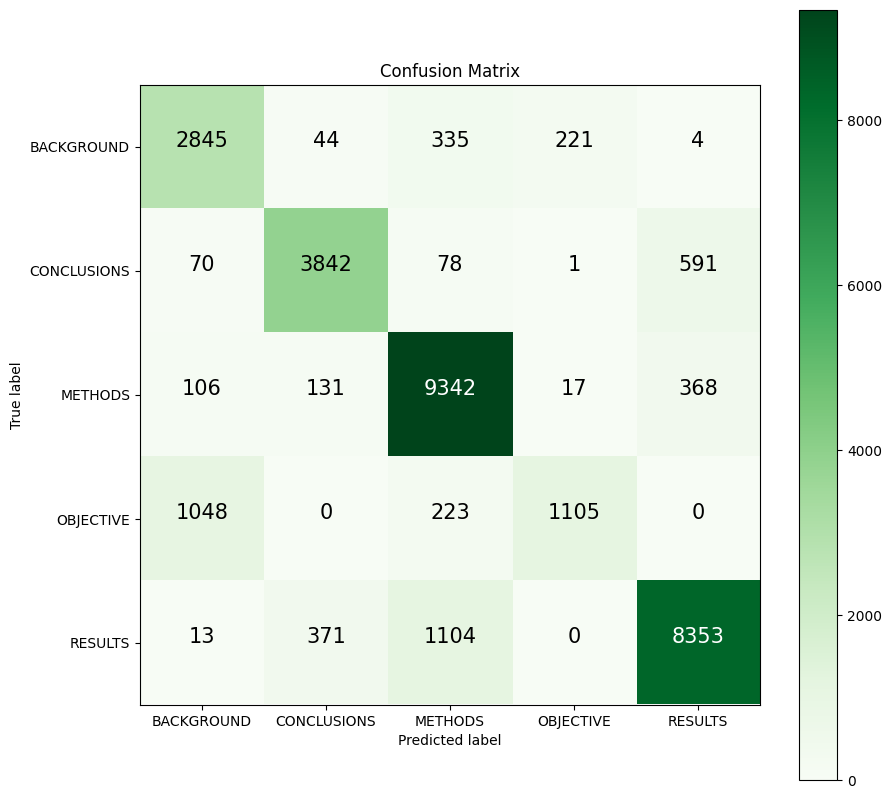

In [100]:
# Confusion Matrix
ModelEvaluation.make_confusion_matrix(dev_labels_encoded, model_5_pred, classes=list(class_names))

In [101]:
# results
model_5_results = ModelEvaluation.results(dev_labels_encoded, model_5_pred)
model_5_results

{'accuracy': 84.36051899907322,
 'precision': 0.8470950194510393,
 'recall': 0.8436051899907322,
 'f1': 0.8397379848088177}

### Compare the results of all the models

In [107]:
model_0_results['Model'] = 'baseline'
model_1_results['Model'] = 'Conv1D'
model_2_results['Model'] = 'tf hub feature extractor'
model_4_results['Model'] = 'LSTM'
model_5_results['Model'] = 'Tribrid'

In [109]:
model_results = [model_0_results, model_1_results, model_2_results,
                 model_4_results, model_5_results]

results_df = pd.DataFrame(model_results).drop('Conv1D', axis=1)
results_df

,accuracy,precision,recall,f1,Model
0,72.183238,0.718647,0.721832,0.698925,baseline
1,77.426188,0.769010,0.774262,0.770662,Conv1D
2,71.597379,0.715836,0.715974,0.712745,tf hub feature extractor
3,73.047134,0.732089,0.730471,0.727992,LSTM
4,84.360519,0.847095,0.843605,0.839738,Tribrid


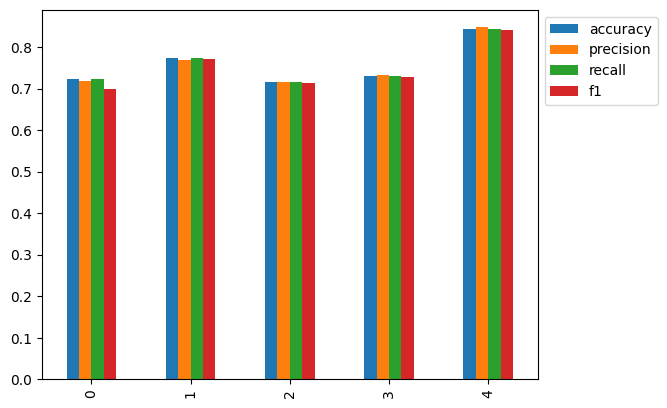

In [115]:
results_df.plot(kind='bar');
plt.legend(bbox_to_anchor=(1.0, 1.0));